In [46]:
import os
import pandas as pd
import numpy as np
import subprocess

# Import mosaic libraries
import missionbio.mosaic as ms

# Import COMPASS for imputation
from missionbio.mosaic.algorithms.compass import COMPASS

# Import graph_objects from the plotly package to display figures when saving the notebook as an HTML
import plotly as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# COMPASS color scale
pal = ['#F08080', '#6CA6CD', '#96CDCD', '#F4A460', '#FFB6C1', '#D8BFD8', '#A2CD5A']

The h5 objects can be obtained upon reasonable request by the authors or by processing the raw fastq files deposited on EGA.

In [47]:
h5path = '/Users/davidfandrei/Nextcloud/PPM1D (2)/Tapestri-h5/'

# Import sc maf
maf_sc = pd.read_excel("../../data/single_cell_data.xlsx", sheet_name = "maf_sc")

# Import bulk maf
maf_bulk = pd.read_excel("../../data/single_cell_data.xlsx", sheet_name = "maf_amplicon_from_bulk")

GR025

In [48]:
gr025 = ms.load(h5path + "M184.dna+protein.h5",
    raw=False,
    filter_variants=False,
    filter_cells=False,
    whitelist = maf_sc[maf_sc["single_cell_id"] == "GR025"]["id"].to_list()
)

            0%: 

In [49]:
dna_vars = gr025.dna.filter_variants(
    min_dp=0,
    min_gq=0,
    vaf_ref=5,
    vaf_hom=95,
    vaf_het=30,
    min_prct_cells=10,
    min_mut_prct_cells=1,
    iterations=10,
)

In [51]:
maf_sc[maf_sc["single_cell_id"] == "GR025"][["id", "SYMBOL", "AA_change", "CONSEQUENCE", "VAF"]]

,id,SYMBOL,AA_change,CONSEQUENCE,VAF
5,chr11:119148931:G/A,CBL,CBL.C384Y,nonsynonymous,0.642479
6,chr12:112888163:G/C,PTPN11,PTPN11.G60A,nonsynonymous,0.879525
7,chr12:112888163:G/C,PTPN11,PTPN11.G60A,nonsynonymous,0.879525
8,chr17:58740427:CT/C,PPM1D,NaN,NaN,35.183639


In [53]:
final_vars_GR025 = list(set(list(dna_vars) + maf_sc[maf_sc["single_cell_id"] == "GR025"]["id"].to_list()))
wfv = ms.workflows.VariantSubcloneTable(gr025)
wfv.run()

In [54]:
variants = wfv.selected_variants
gr025.dna = gr025.dna[:,variants]

In [55]:
wfc = ms.workflows.CopyNumber(gr025)
wfc.run()

In [56]:
gr025_clusters = ['WT', 'PPM1D_Het','small']

In [57]:
gr025.protein = gr025.protein.drop(['CD22'])
gr025.protein.normalize_reads('CLR')

In [58]:
gr025.protein = gr025.protein.drop(['IgG2a', 'IgG2b'])

In [59]:
# CNV order
ordered_cnv_gr025 = gr025.cnv.barcodes(label=gr025_clusters)[::-1]

In [60]:
fig = gr025.heatmap(
    ("dna", "cnv", "protein"),
    attributes=("NGT_FILTERED", "ploidy", "normalized_counts"),
    features=(variants, ["1", "11"], None),
    widths= [0.75, 0.5, 1],
    bars_order= ordered_cnv_gr025,
)

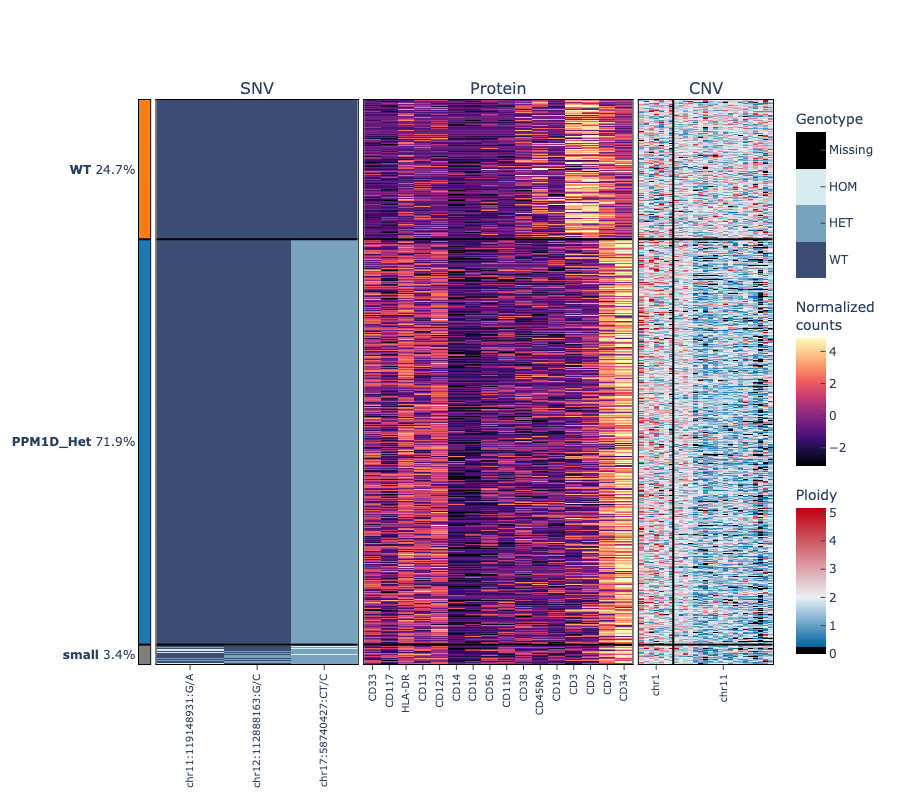

In [61]:
new_palette = {
    'WT': pal[0],
    'PPM1D_Het': pal[1],
    'small' : "#7f7f7f"
}

gr025.dna.set_palette(new_palette)

# Update the width of the plot [See the section on CNV heatmaps]
fig.layout.width = 900
fig.update_layout(title="")

# Show a static plot
fig.show("png")

In [23]:
fig.write_image(
    "../../figures/main/figure_5/fig_5f.png",
    scale=5
)

GR017

In [30]:
gr017 = ms.load(h5path + "M182.dna+protein.h5",
    raw=False,
    filter_variants=True,
    filter_cells=False,
    whitelist = maf_sc[maf_sc["single_cell_id"] == "GR017"]["id"].to_list()
)

            0%: 

In [25]:
dna_vars = gr017.dna.filter_variants(
    min_dp=10,
    min_gq=30,
    vaf_ref=5,
    vaf_hom=95,
    vaf_het=30,
    min_prct_cells=50,
    min_mut_prct_cells=1,
    iterations=10,
)
final_vars_gr017 = list(set(list(dna_vars) + maf_sc[maf_sc["single_cell_id"] == "M182"]["id"].to_list()))
gr017.dna = gr017.dna[:, final_vars_gr017]

In [26]:
maf_sc[maf_sc["single_cell_id"] == "GR017"][["id", "SYMBOL", "AA_change", "CONSEQUENCE", "VAF"]]

,id,SYMBOL,AA_change,CONSEQUENCE,VAF
21,chr21:36231792:C/T,RUNX1,RUNX1.D198N,nonsynonymous,21.808815
22,chr17:58740376:G/A,PPM1D,PPM1D.W427*,nonsense,26.547842
23,chr4:106162587:G/T,TET2,NaN,NaN,45.807003


In [28]:
final_vars_GR025 = list(set(list(dna_vars) + maf_sc[maf_sc["single_cell_id"] == "GR017"]["id"].to_list()))
wfv = ms.workflows.VariantSubcloneTable(gr017)
wfv.run()

In [114]:
variants = wfv.selected_variants
gr017.dna = gr017.dna[:,variants]

In [115]:
clones = ['missing', 'small', 'ADO', 'FP']
for c in clones:
    cells = gr017.dna.barcodes({c})
    if len(cells) > 0:
        gr017.dna = gr017.dna.drop(cells)

gr017.dna.rename_labels({ 
   '2': 'PPM1D_Het/TET2_Hom/<br>RUNX1_Het',  
   '4': 'PPM1D_Het/TET2_Het/<br>RUNX1_Het', 
})

new_palette = {
    'WT': pal[0],
    'PPM1D_Het': pal[3],
    'PPM1D_Het/TET2_Het/<br>RUNX1_Het': pal[1],
    'PPM1D_Het/TET2_Hom/<br>RUNX1_Het': pal[2],
}

gr017.dna.set_palette(new_palette)

# SNV order
gr017_clusters = ['WT', 'PPM1D_Het', 'PPM1D_Het/TET2_Het/<br>RUNX1_Het', 'PPM1D_Het/TET2_Hom/<br>RUNX1_Het']
ordered_snv_gr017 = gr017.dna.barcodes(label=gr017_clusters)[::-1]

In [117]:
wfc = ms.workflows.CopyNumber(gr017)
wfc.run()

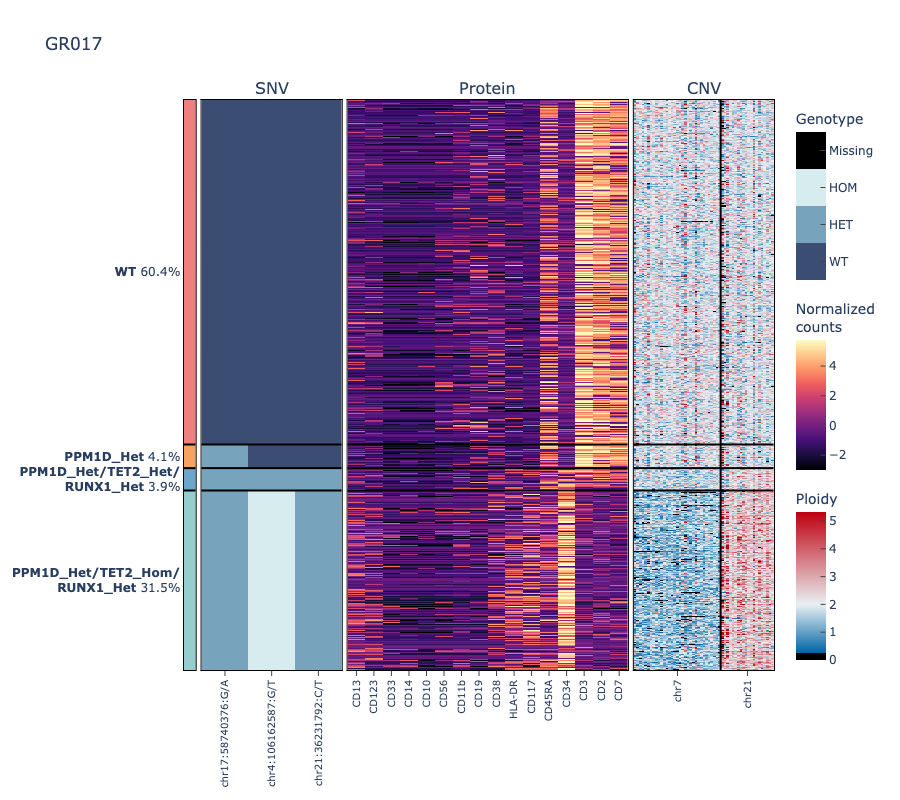

In [118]:
# Protein
gr017.protein = gr017.protein.drop('CD22')
gr017.protein.normalize_reads('CLR')
gr017.protein = gr017.protein.drop(['IgG2a', 'IgG2b'])

# CNV order
ordered_cnv_gr017 = gr017.cnv.barcodes(label=gr017_clusters)[::-1]

# Creating the same plot again will 
fig = gr017.heatmap(
    ("dna", "cnv", "protein"),
    attributes=("NGT_FILTERED", "ploidy", "normalized_counts"),
    features=(['chr17:58740376:G/A', 'chr4:106162587:G/T', 'chr21:36231792:C/T'], ["7", "21"], None),
    widths= [0.5,0.5, 1],
    bars_order= ordered_cnv_gr017
)

# Update the width of the plot [See the section on CNV heatmaps]
fig.layout.width = 900
fig.update_layout(title="GR017")

# Show a static plot
fig.show("png")

In [119]:
fig.write_image(
    "../../figures/main/figure_5/fig_5c.png",
    scale=5
)